In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from numpy import pi
import ephem
from tqdm import tqdm
import reverse_geocoder as rg
from collections import Counter
import networkx as nx
from multiprocessing import Pool
from scipy import sparse, stats, spatial, linalg
from pygsp import graphs, filters, plotting
from mpl_toolkits.basemap import Basemap
import sklearn
import itertools
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [2]:
def read_tle(tle_file):
    tle = open(tle_file)
    lines = tle.readlines()
    return lines

In [3]:
lines_current = read_tle('Dataset/satellite_tle_current.txt')
#lines_globalstar = read_tle('Dataset/telecom_sat_tle/globalstar.csv')
#lines_inmarsat = read_tle('Dataset/telecom_sat_tle/inmarsat.csv')
#lines_intelsat = read_tle('Dataset/telecom_sat_tle/intelsat.csv')
#lines_iridium = read_tle('Dataset/telecom_sat_tle/iridium.csv')
#lines_orbcom = read_tle('Dataset/telecom_sat_tle/orbcom.csv')
lines_tot = lines_current#+lines_globalstar[:-1]+lines_inmarsat[:-1]+lines_intelsat[:-1]+lines_iridium[:-1]+lines_orbcom[:-1]
#useless as none of the satellites are in the other merged csv file hence everything is deleted

In [4]:
lines_tot.count('\n')

0

In [5]:
def compute_tle_informations(lines):
    numb_element = len(lines)
    names = []
    long = []
    lat = []
    elevation_km = []
    for i in range(0,numb_element-1,3):
        temp = ephem.readtle(lines[i], lines[i+1], lines[i+2])
        temp.compute('2017/10/12')
        try:
            long.append(temp.sublong*180/pi)
            lat.append(temp.sublat*180/pi)
            elevation_km.append(temp.elevation/1000)
            names.append(temp.name[2:])
        except:
            print('Index number {} is not compatible to perform computation' .format(i))
    return names,long,lat,elevation_km

In [6]:
names,long,lat,elevation_km = compute_tle_informations(lines_tot)
data = pd.DataFrame(np.transpose([names,long,lat,elevation_km]))
data.columns = ['OBJECT_NAME','Longitude [°]','Latitude [°]','Elevation [km]']

#useless to compute this single longitude/lattitude.

Index number 5361 is not compatible to perform computation
Index number 49563 is not compatible to perform computation


In [7]:
coord = list(zip(lat,long))
result = rg.search(coord)
countries = [temp['cc'] for temp in result]
data['Country'] = countries

Loading formatted geocoded file...


In [8]:
data

OBJECT_NAME        Longitude [°]          Latitude [°]  \
0                  VANGUARD 1   -63.01315328238157    -26.65173623575367   
1                  VANGUARD 2   33.607191075144456    -32.25819456312109   
2                VANGUARD R/B   158.90670062542114    1.4622271746404283   
3                VANGUARD R/B  -117.00344908625789    12.395302654786787   
4                  VANGUARD 3  -14.979412519707317   -30.811335100669776   
5                  EXPLORER 7    165.9903034740197     9.845133707399345   
6                     TIROS 1   -49.25634633165384     48.00799948723977   
7                  TRANSIT 2A  -139.31569634983023     38.87243705724013   
8             SOLRAD 1 (GREB)  -0.5891223854904057    -47.06758489136657   
9           THOR ABLESTAR R/B    53.80098686574566    -2.196176677848373   
10                DELTA 1 R/B   16.734574768461957     44.07962984648528   
11     ECHO 1 DEB (METAL OBJ)   -145.5923533291268     46.95078182637018   
12     ECHO 1 DEB (METAL OBJ)    78.34966687491738    43.073129755297614   
13                 COURIER 1B   114.70821865718847    26.553926219291796   
14          THOR ABLESTAR R/B   -71.05553710553151     27.84040942493662   
15              SCOUT X-1 R/B  -1.0104453792069925     18.81512552172871   
16              SCOUT X-1 DEB  -178.24063024103108   -33.450270894057994   
17                EXPLORER 11    88.75746815104779    11.330060375416075   
18         THOR ABLE DEB (YO)  -137.34696262346577    -43.83034160215816   
19                 TRANSIT 4A    83.81698741870247     41.28820666478194   
20           SOLRAD 3/INJUN 1   142.82015712993706   -15.470562885186471   
21          THOR ABLESTAR R/B  -10.550542838273568   -47.337360288109146   
22          THOR ABLESTAR DEB  -172.21582965718957    -65.85418412802672   
23          THOR ABLESTAR DEB   155.00264645811188     55.52819144268014   
24          THOR ABLESTAR DEB   139.99520454959813    32.676745140364886   
25          THOR ABLESTAR DEB  -116.15022185513989     8.493485374430719   
26          THOR ABLESTAR DEB    147.7982175630958    -48.36096658807311   
27          THOR ABLESTAR DEB   10.107990976286347    62.718683336694816   
28          THOR ABLESTAR DEB    91.82177105047148   -18.493333111814607   
29          THOR ABLESTAR DEB  -160.31784502870246    14.209967804043286   
...                       ...                  ...                   ...   
16699             BEIDOU-3 M2   132.90981219143703     -20.7339510558279   
16700                YZ-1 R/B   123.88312980699655   -29.976289833122358   
16701               CZ-3B R/B    57.07589864822669    -54.17941349671021   
16702           MOHAMMED VI-A    141.4915623929645    -59.05027752594018   
16703             CYGNUS 0A-8   168.69154766811135     16.31860429517713   
16704             ANTARES R/B   -147.6647693270921   -50.936528471247364   
16705             ANTARES DEB  -157.81392499973245    -44.77979595339787   
16706             ANTARES DEB    90.62990304030426      4.11227163038344   
16707              FENGYUN 3D   18.985163081116177    -36.10732376421968   
16708                  HEAD-1  -113.88546773014707    -76.98478334288455   
16709               CZ-4C R/B  -147.23021903171752   -46.975749582881164   
16710                  JPSS 1   -132.1787224030572     -71.1102264302158   
16711           BUCCANEER RMM    55.72630107955636     76.61878765620942   
16712                  MIRATA  -158.91164568238023  -0.07054327430516273   
16713                OBJECT D  -154.86430780666245   -27.724431105282513   
16714                OBJECT E  -154.49387932721598   -29.830690690585193   
16715                OBJECT F  -154.79741293393135    -28.11150817083089   
16716                 ECAMSAT     123.958193585975   -33.394693644781604   
16717                 ASTERIA   159.41994836041258     5.154561485935148   
16718         DELLINGR (RBLE)    140.9195203895976    -17.50596438049215   
16719             JILIN-01-04   1.7067377016431298   -11.639395374

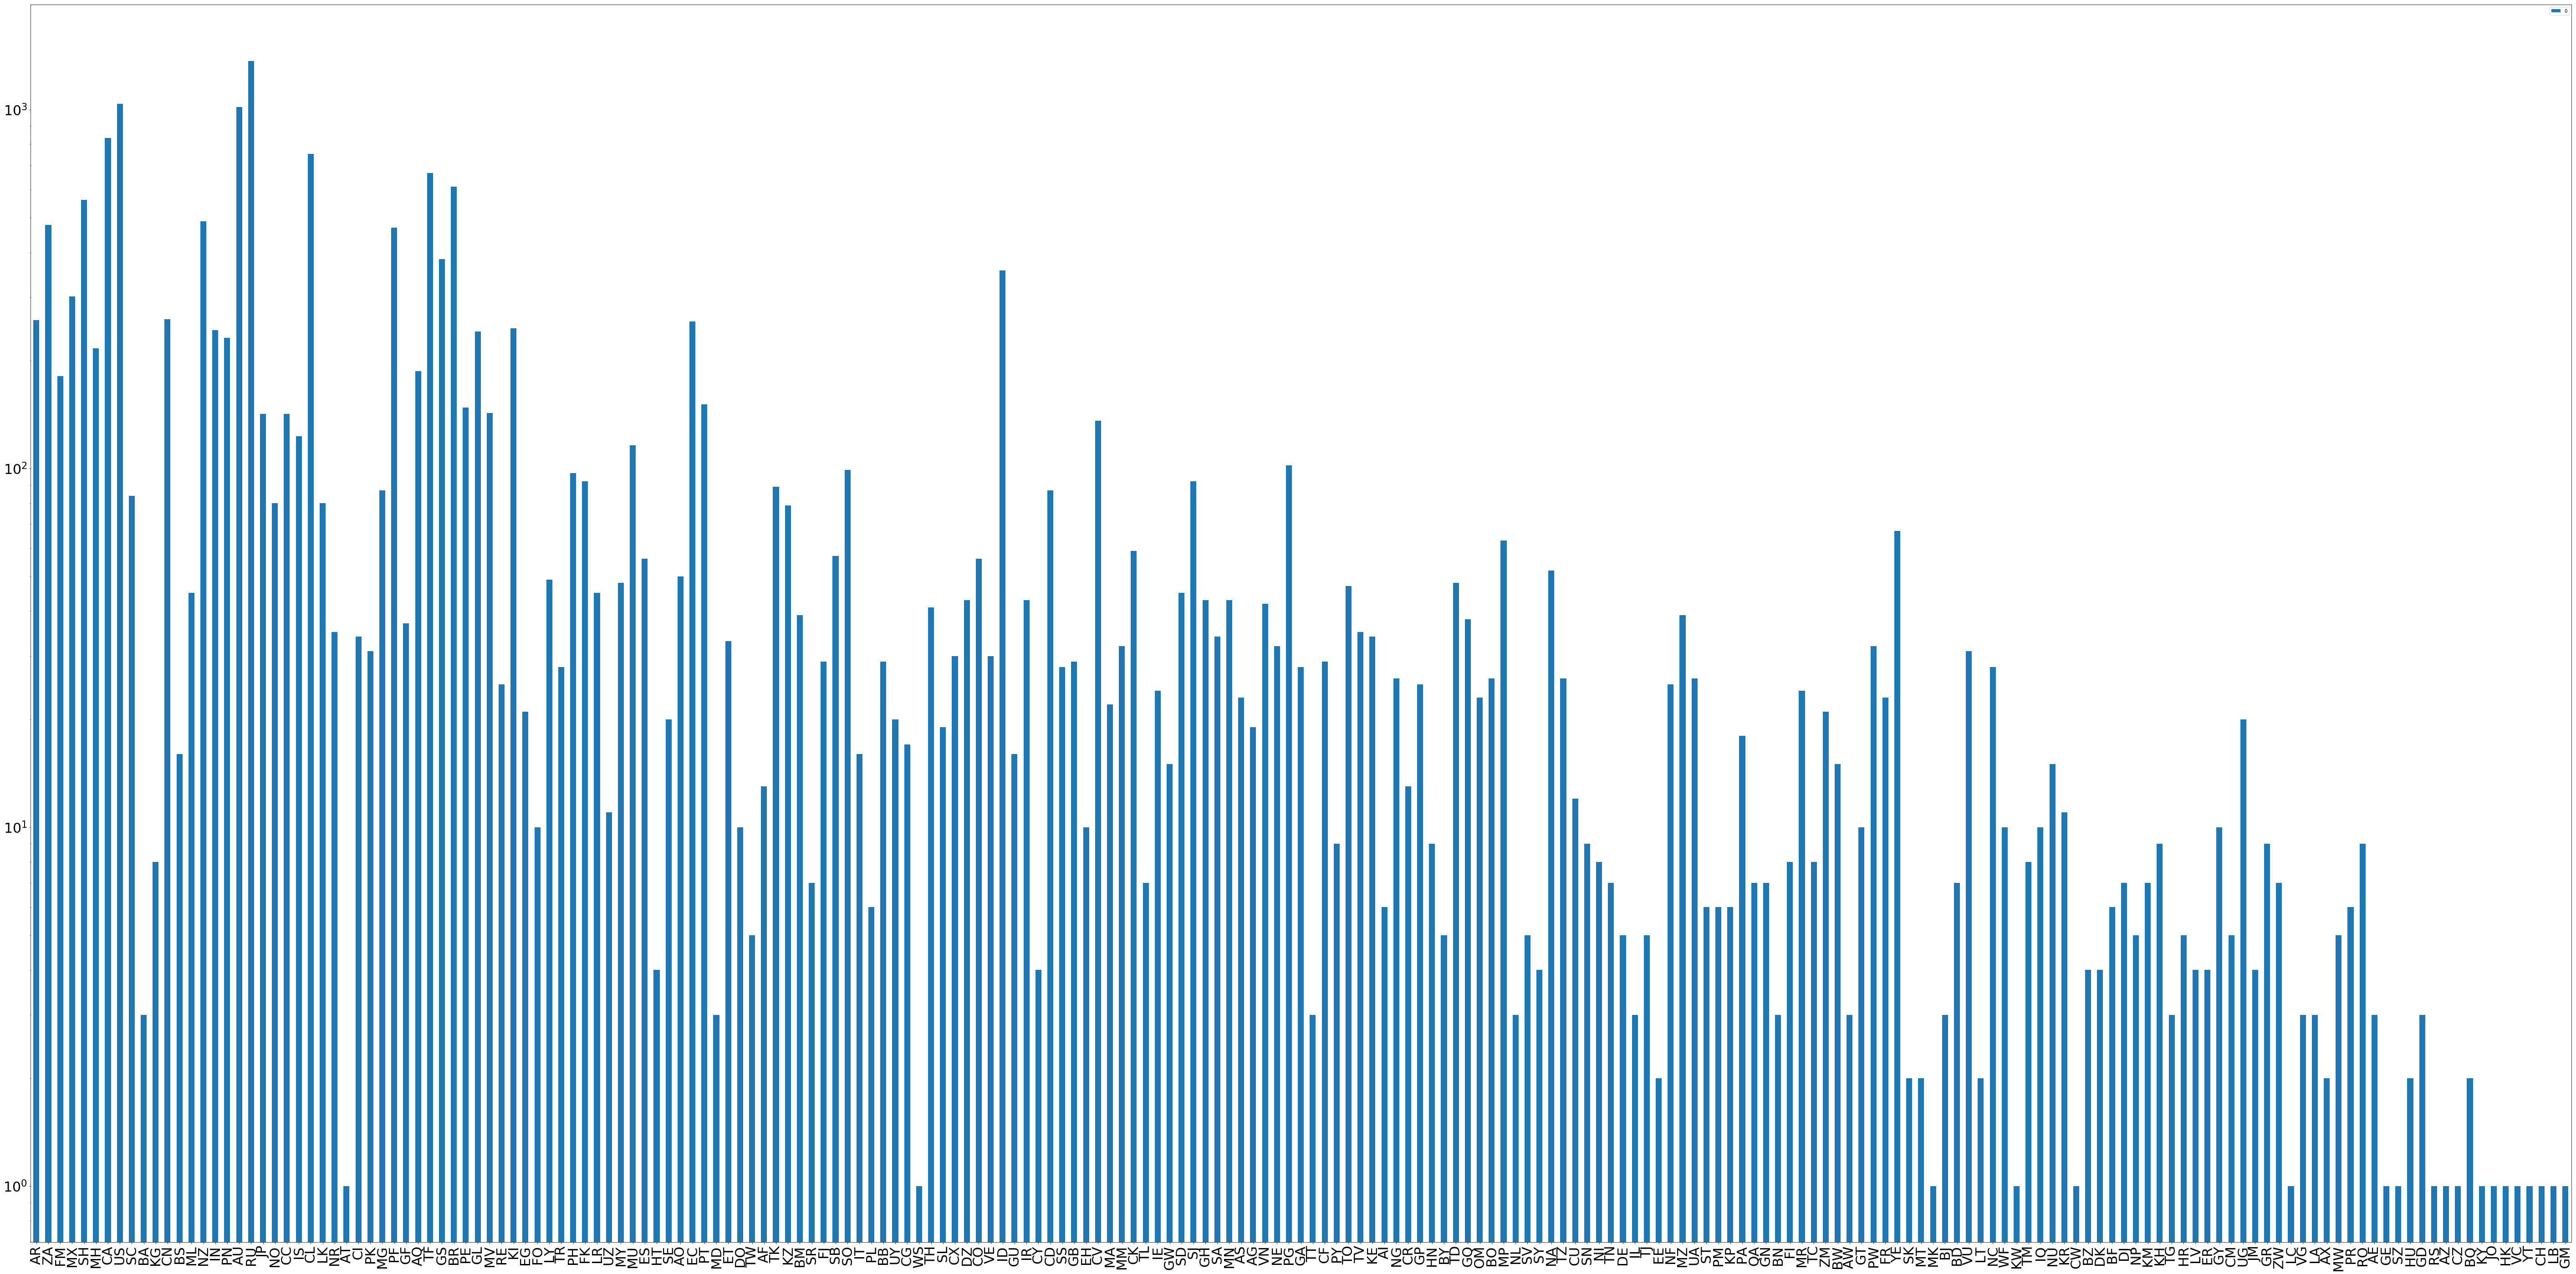

In [9]:
letter_counts = Counter(data['Country'])
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar',figsize=(100,50),logy=True,fontsize=30)

In [10]:
len(np.unique(data['Country']))

213

In [11]:
sioi = pd.read_csv('Dataset/satellites_in_orbit_info.csv')

In [12]:
no_deb = data[["DEB" not in x for x in data.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")

In [13]:
sioi = sioi[["DEB" not in x for x in sioi.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")

In [14]:
data_m = pd.merge(no_deb,sioi,how='inner', on="OBJECT_NAME")

In [15]:
#mask = (data_m['Elevation [km]'].astype('float64') < 30000)
#data_final = data_m[mask]

In [17]:
data_final = data_m.dropna(axis= 0, subset=["PERIOD"])

In [18]:
data_final

OBJECT_NAME        Longitude [°]          Latitude [°]  \
0               VANGUARD 1   -63.01315328238157    -26.65173623575367   
1               VANGUARD 2   33.607191075144456    -32.25819456312109   
2             VANGUARD R/B   158.90670062542114    1.4622271746404283   
3               VANGUARD 3  -14.979412519707317   -30.811335100669776   
4               EXPLORER 7    165.9903034740197     9.845133707399345   
5                  TIROS 1   -49.25634633165384     48.00799948723977   
6               TRANSIT 2A  -139.31569634983023     38.87243705724013   
7          SOLRAD 1 (GREB)  -0.5891223854904057    -47.06758489136657   
8        THOR ABLESTAR R/B    53.80098686574566    -2.196176677848373   
9              DELTA 1 R/B   16.734574768461957     44.07962984648528   
10              COURIER 1B   114.70821865718847    26.553926219291796   
11           SCOUT X-1 R/B  -1.0104453792069925     18.81512552172871   
12             EXPLORER 11    88.75746815104779    11.330060375416075   
13              TRANSIT 4A    83.81698741870247     41.28820666478194   
14        SOLRAD 3/INJUN 1   142.82015712993706   -15.470562885186471   
15                 TIROS 3   164.74275576173852  -0.40550982512753797   
16                 MIDAS 3  -140.61302248078246    -74.17635299014789   
17                 MIDAS 4   120.26868932087419     81.63412726185808   
18              TRANSIT 4B  -135.09819114113077    -17.32939716025815   
19                   TRAAC   -51.85684865058239      7.28968075491525   
20                 TIROS 4  -123.36699973217537    -34.60518075062628   
21    MIDAS 5 (STRONGBACK)   -147.9712535755289    51.014990269337886   
22                 TIROS 5  -116.61115034108904    -43.38847275908793   
23               TELSTAR 1    82.27867172326468     4.368588993140156   
24                FTV 3502   121.01705948785414    -75.01721757886816   
25                 TIROS 6  -28.640279218258474   -26.098851205461354   
26       ALOUETTE 1 (S-27)  -35.224265681901656    -55.00394710312498   
27        THOR AGENA B R/B   123.72279794641967    -55.08123069358368   
28                 ANNA 1B   -74.40594296890869     15.67887682468269   
29          RELAY 1 (A-15)   -87.86564352093005    39.164516436717385   
...                    ...                  ...                   ...   
4332            SKYSAT C10   146.85443568396178    -80.72256338503902   
4333             SKYSAT C9  -172.95226065350033    -58.16346625467323   
4334             SKYSAT C8  -163.23892569142015   -17.042126233956584   
4335             SKYSAT C7   -161.4285977122866    -3.486841026482305   
4336             SKYSAT C6  -158.64470822923778    17.564287365814888   
4337            FLOCK 3M 1  -160.21218200224234     5.824200489239192   
4338            FLOCK 3M 3   -158.6969318556317    17.041246847100943   
4339            FLOCK 3M 4  -157.85303466291995    23.073159365415748   
4340            FLOCK 3M 2  -154.25974044246794    42.264230451893006   
4341           BEIDOU-3 M1    158.1729743840217     13.75057098801552   
4342           BEIDOU-3 M2   132.90981219143703     -20.7339510558279   
4343         MOHAMMED VI-A    141.4915623929645    -59.05027752594018   
4344           CYGNUS 0A-8   168.69154766811135     16.31860429517713   
4345            FENGYUN 3D   18.985163081116177    -36.10732376421968   
4346                HEAD-1  -113.88546773014707    -76.98478334288455   
4347                JPSS 1   -132.1787224030572     -71.1102264302158   
4348         BUCCANEER RMM    55.72630107955636     76.61878765620942   
4349                MIRATA  -158.91164568238023  -0.07054327430516273   
4350              OBJECT D  -154.86430780666245   -27.724431105282513   
4351               ECAMSAT     123.958193585975   -33.394693644781604   
4352               ASTERIA   159.41994836041258     5.154561485935148   
4353       DELLINGR (RBLE)    140.9195203895976    -17.50596438049215   
4354           JILIN-01-04   1.7067377016431298   -11.639395374057722   


In [19]:
dict_tle = {}
for i in range(0,len(lines_tot)-1,3):
    dict_tle[lines_tot[i][2:].strip('\n')] = (lines_tot[i+1],lines_tot[i+2])

In [20]:
keys = list(dict_tle.keys())
for i in keys:
    if i not in data_final['OBJECT_NAME'].values:
        del dict_tle[i]

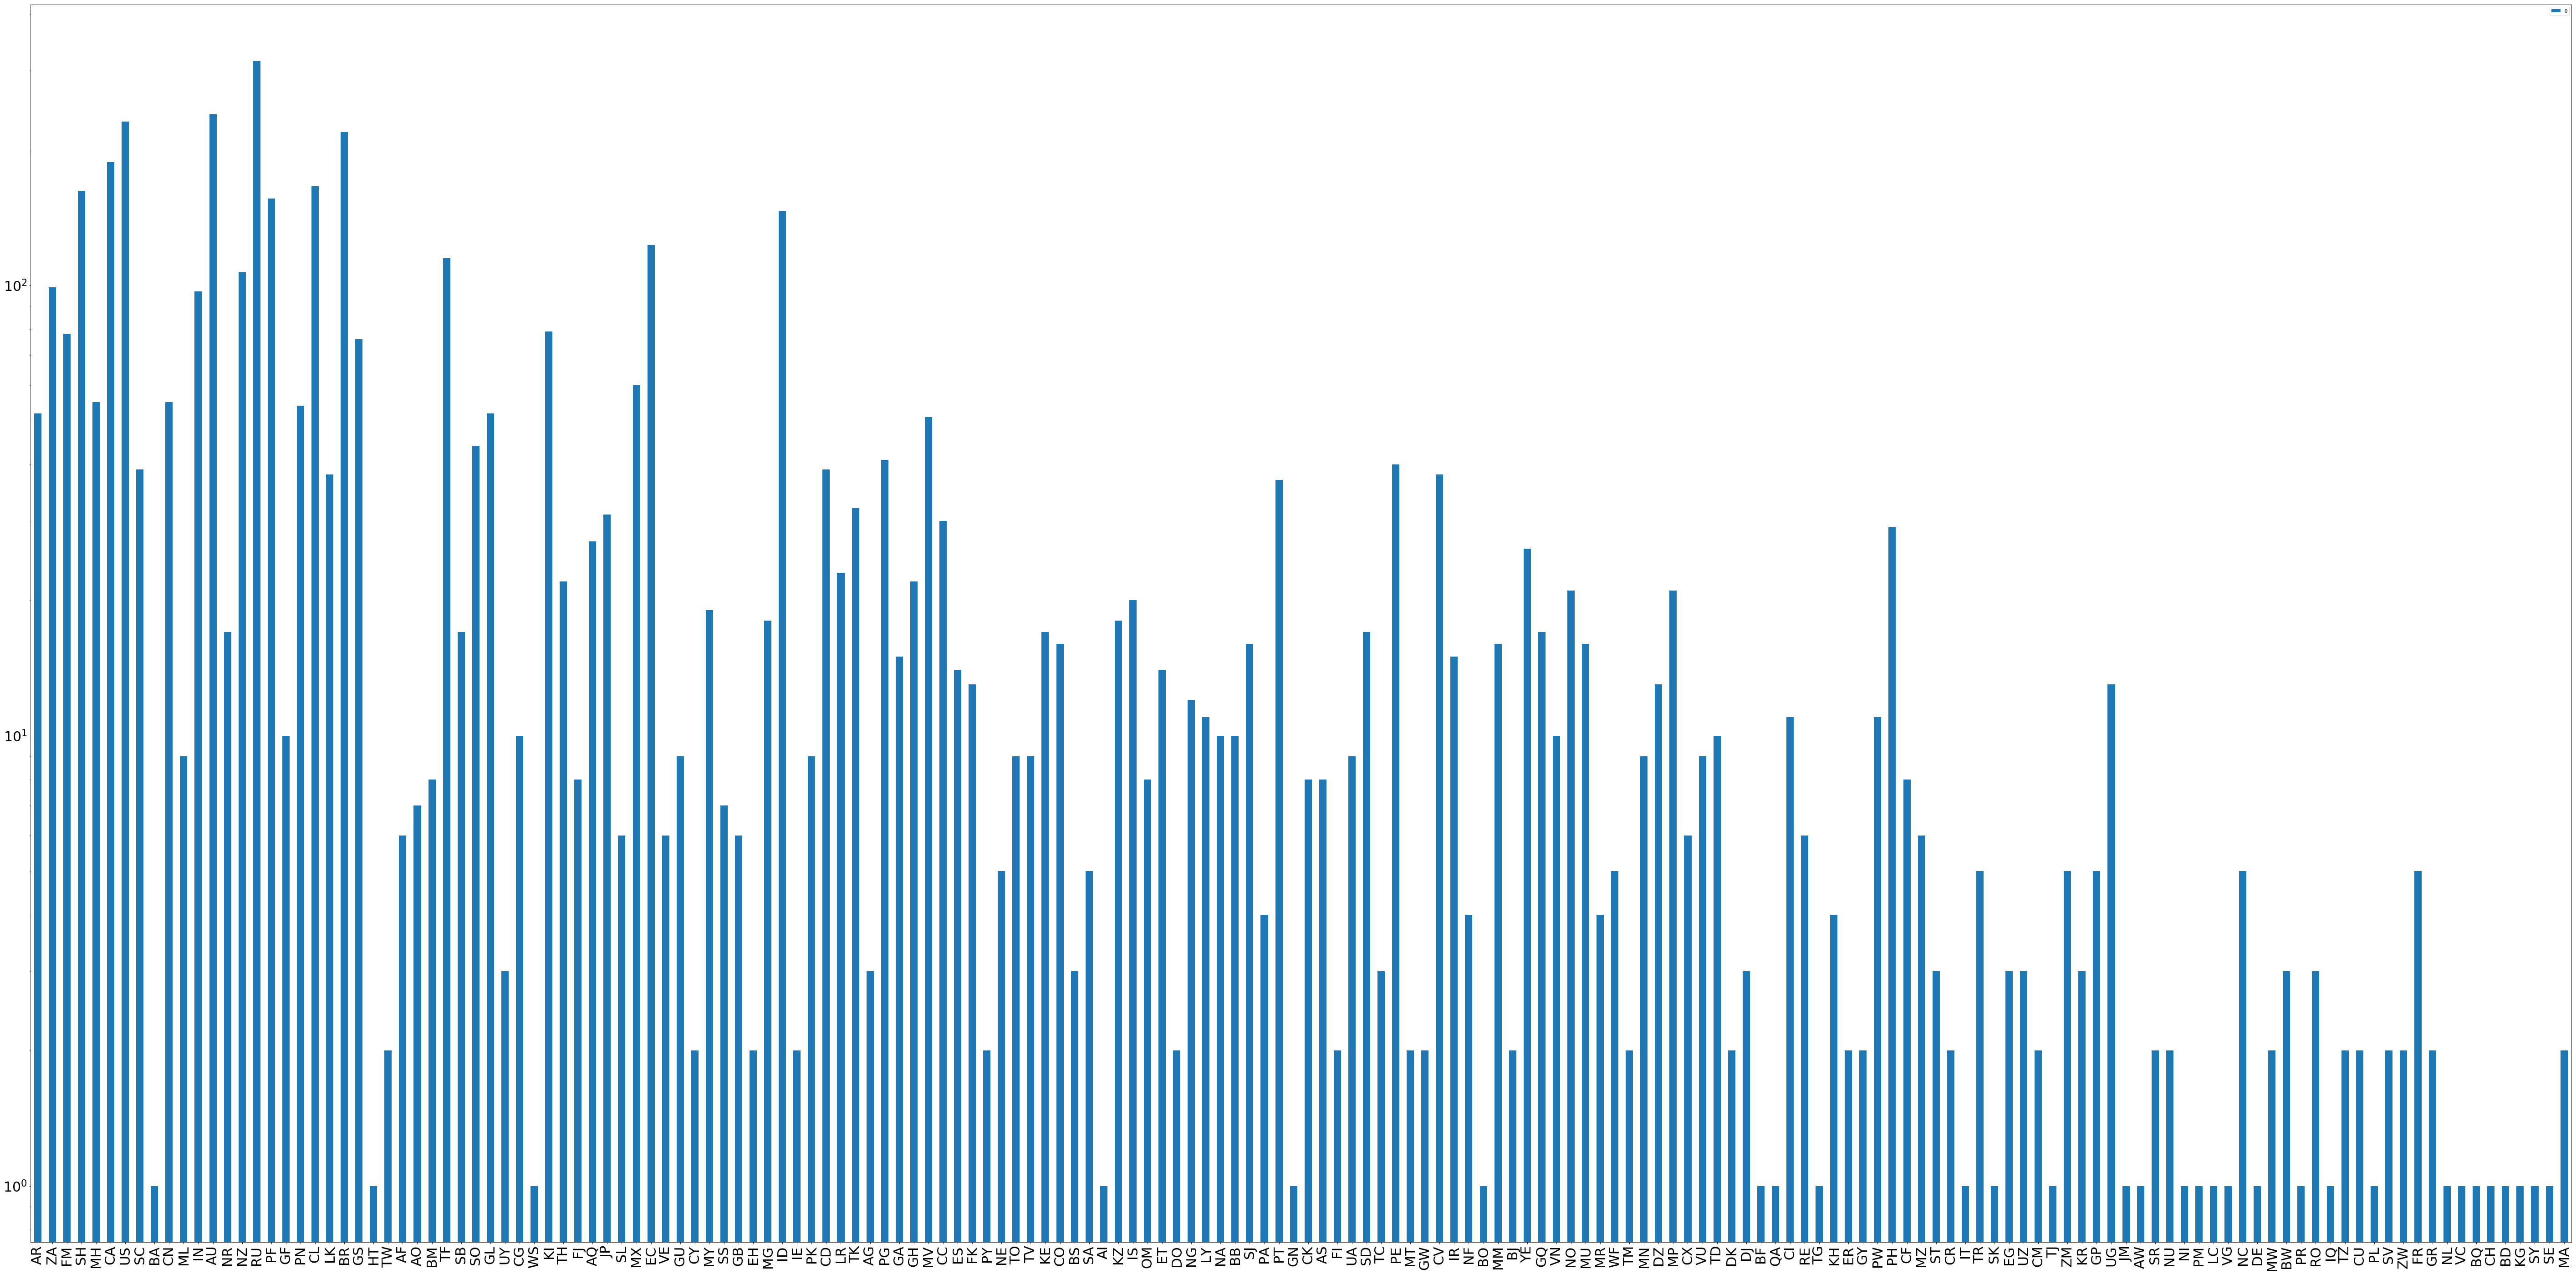

In [21]:
letter_counts = Counter(data_final['Country'])
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar',figsize=(100,50),logy=True,fontsize=30)

In [22]:
def satellite_orbit(name):
    orbit_point = []
    line_1, line_2 = dict_tle[name]
    period = int(sioi[sioi.OBJECT_NAME == name].PERIOD.values[0])
    delta_t = int(period*60/nb_point)
    delta_t = timedelta(seconds = delta_t)
    time = datetime(2017,10,12)
    l1, l2 = dict_tle[name]
    temp = ephem.readtle(name, l1, l2)
    for i in range(0,200):
        time = time + delta_t
        temp.compute(time)
        try:
            lat = temp.sublat*180/pi
            long = temp.sublong*180/pi
            orbit_point.append((lat,long))
        except:
            print("ERROR")
    return orbit_point

In [23]:
nb_point = 200
p = Pool()
res = p.map(satellite_orbit, list(dict_tle.keys()))

In [24]:
def compute_grids(res):
    orbit_grids= []
    vertical_offset =90
    horizontal_offset = 180
    shape = (180,360)
    coverage_width = range(-7, 7)
    for stats in res:
        grid = np.zeros(shape)
        for lat, long in stats:
            lat = round(lat) + vertical_offset
            long = round(long) + horizontal_offset
            for i in coverage_width:
                for j in coverage_width:
                    grid[(lat+i)%shape[0]][(long+j)%shape[1]] = 1
        orbit_grids.append(grid)
    return orbit_grids

In [25]:
orbit_grids = compute_grids(res)

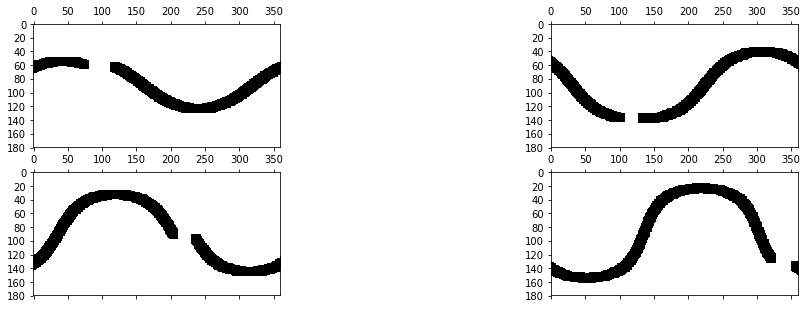

In [26]:
fig, axes = plt.subplots(2,2)
axes[0,0].spy(orbit_grids[0])
axes[0,1].spy(orbit_grids[5])
axes[1,0].spy(orbit_grids[100])
axes[1,1].spy(orbit_grids[1000])

In [27]:
def plot_map(data_final,labels1=None,label_value=None):
    plt.figure(figsize=(20,10))
    eq_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
                  lat_0=0,lon_0=0)
    eq_map.drawcoastlines()
    eq_map.drawcountries()
    eq_map.bluemarble()
    eq_map.drawmapboundary()
    eq_map.drawmeridians(np.arange(0, 360, 30))
    eq_map.drawparallels(np.arange(-90, 90, 30))

    if labels1 is not None:
        long = data_final['Longitude [°]'].values[labels1==label_value]
        lat = data_final['Latitude [°]'].values[labels1==label_value]
    else:
        long = data_final['Longitude [°]'].values
        lat = data_final['Latitude [°]'].values
    lons,lats = eq_map(long,lat)
    eq_map.scatter(lons, lats, marker = 'o', color='y', zorder=1)
    plt.show()

In [28]:
def dbscan_func(G,epsilon,mn,labels=None,label_value=None):
    centers = [[1, 1], [-1, -1], [1, -1]]
    if labels is not None:
        X = G.coords[labels==label_value]
    else:
        X = G.coords

    X = StandardScaler().fit_transform(X)

    # #############################################################################
    # Compute DBSCAN
    db = DBSCAN(eps= epsilon, min_samples = mn).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels1 = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
    # #############################################################################
    # Plot result
    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    unique_labels = set(labels1)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels1 == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return labels1

In [29]:
def compute_weight(sat1,sat2):
    tot = np.logical_and(sat1,sat2)
    return np.sum(tot)

In [30]:
def compute_adja(orbit_grids):
    adja = np.zeros([len(orbit_grids),len(orbit_grids)])
    for n1,i1 in enumerate(orbit_grids):
        for n2,i2 in enumerate(orbit_grids[n1+1:]):
            adja[n1,n2+n1+1] = compute_weight(i1,i2)
    return adja + np.transpose(adja)

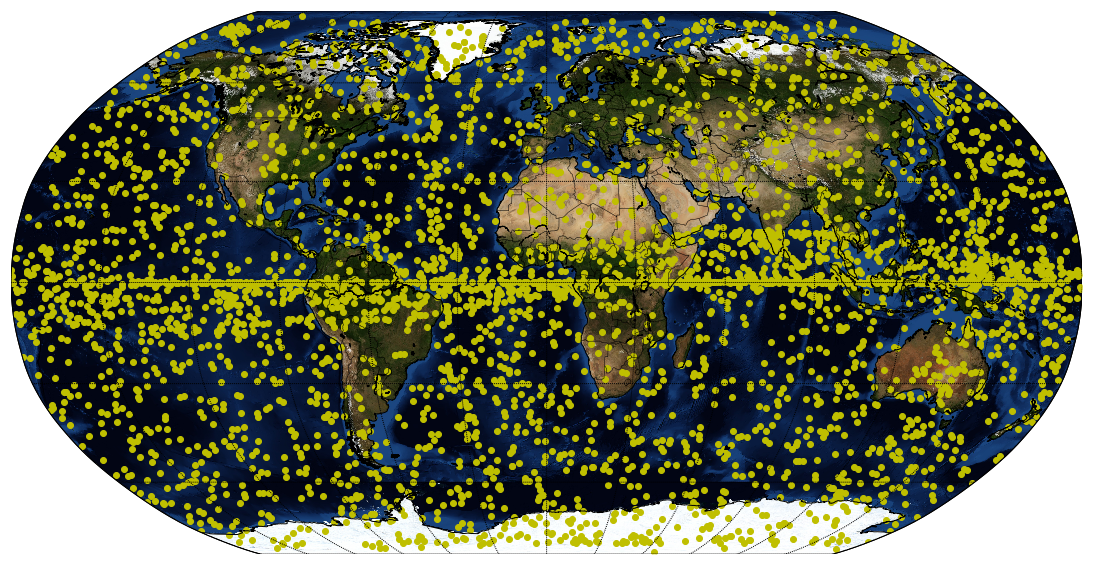

In [31]:
plot_map(data_final)

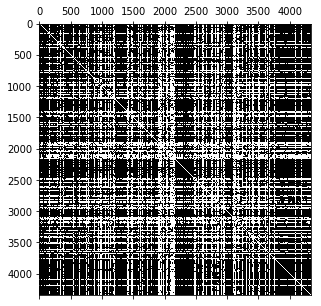

In [32]:
adja = compute_adja(orbit_grids)
plt.spy(adja)

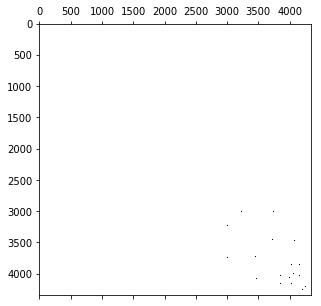

In [33]:
final = adja*(adja>8500)
plt.spy(final)

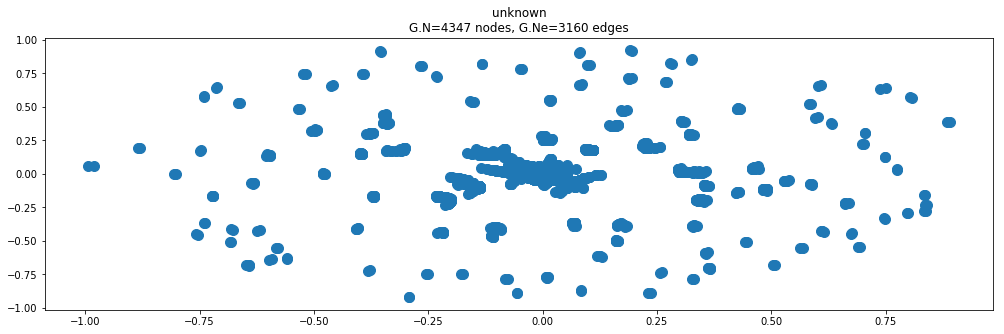

In [34]:
G = graphs.Graph(final)
G.set_coordinates('spring')
G.plot()

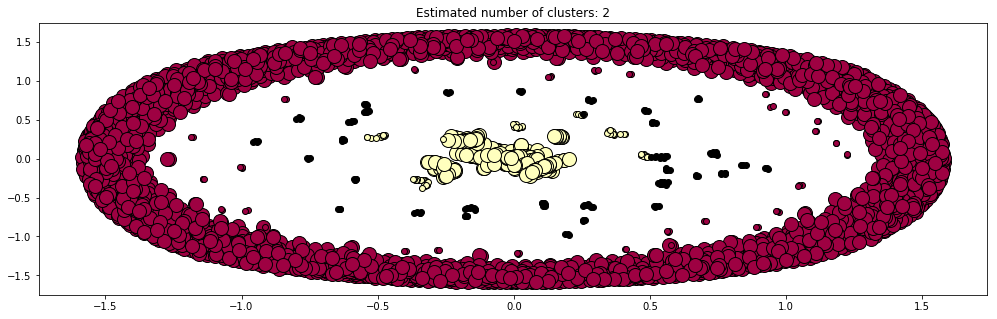

In [35]:
labels1 = dbscan_func(G,0.3,100)

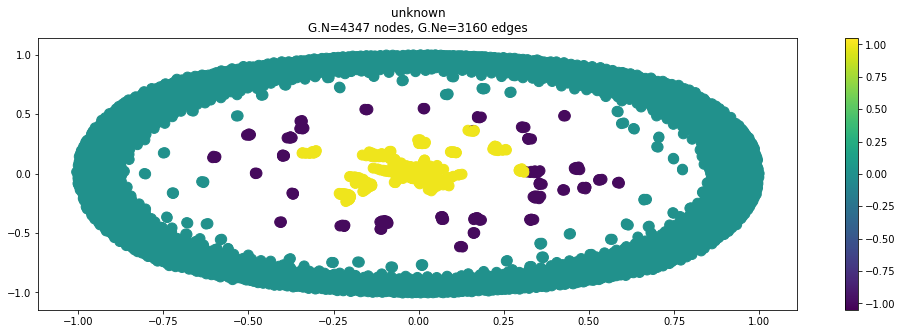

In [36]:
G.plot_signal(labels1)

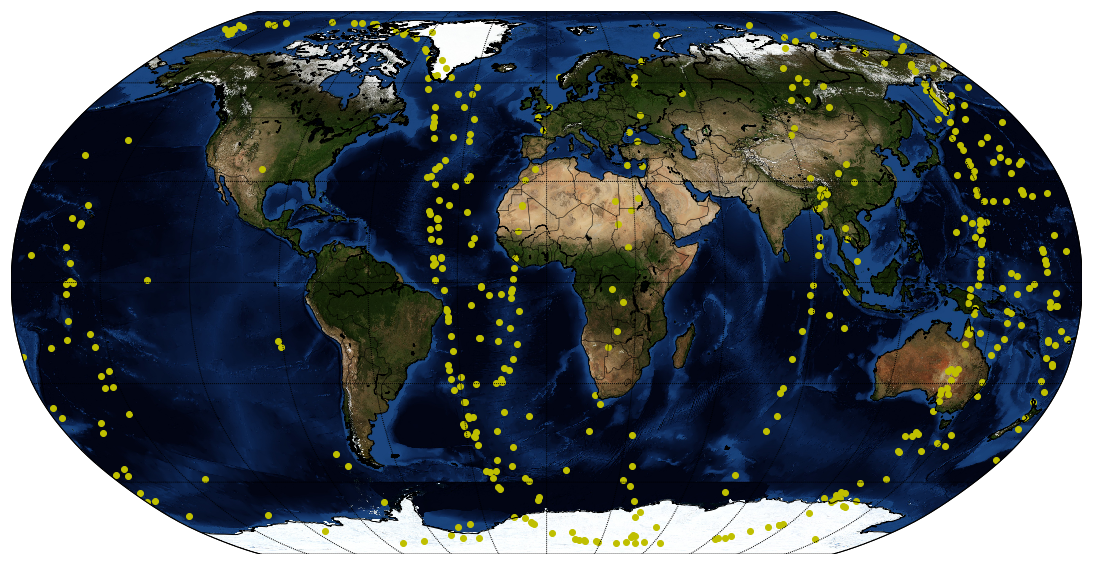

In [37]:
plot_map(data_final,labels1,1)

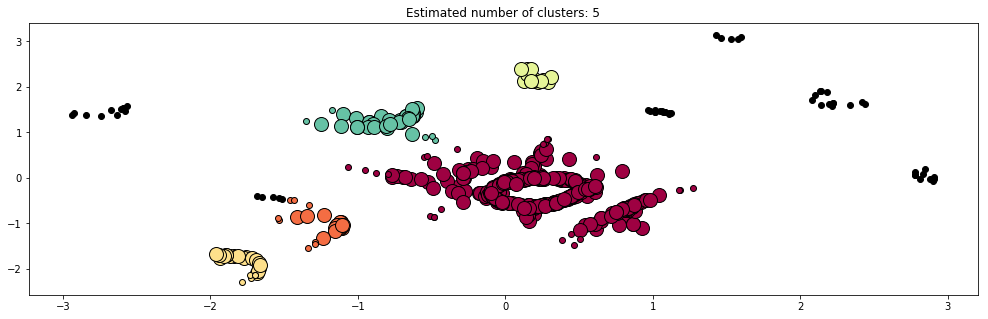

In [38]:
labels2 = dbscan_func(G,0.4,15,labels1,1)

In [39]:
indices = np.where(labels1==1)
labels3 = np.ones(len(labels1))*(-2)
labels3[[indices]] = labels2

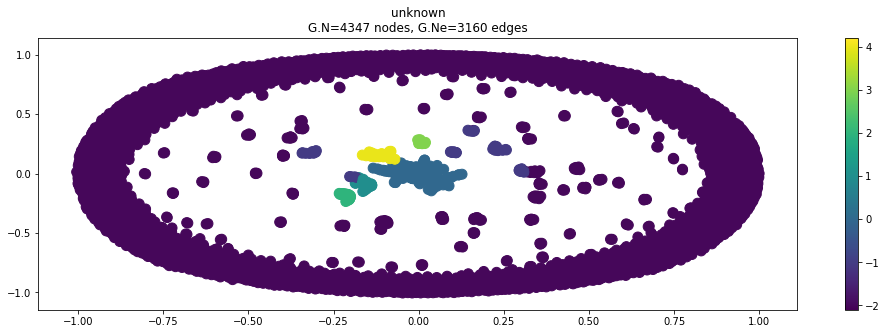

In [40]:
G.plot_signal(labels3)

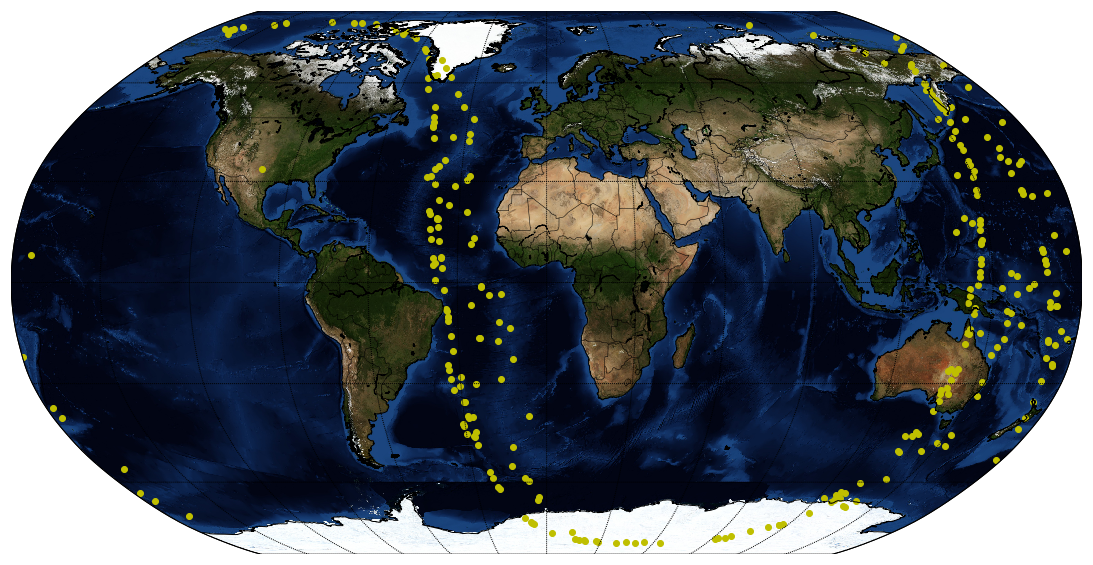

In [42]:
plot_map(data_final,labels3,0)

In [87]:
summm = np.zeros([len(orbit_grids),1])
for n,i in enumerate(orbit_grids):
    summm[n] = np.sum(i)

In [88]:
summm = summm*(summm<500)

In [89]:
mask = summm>0

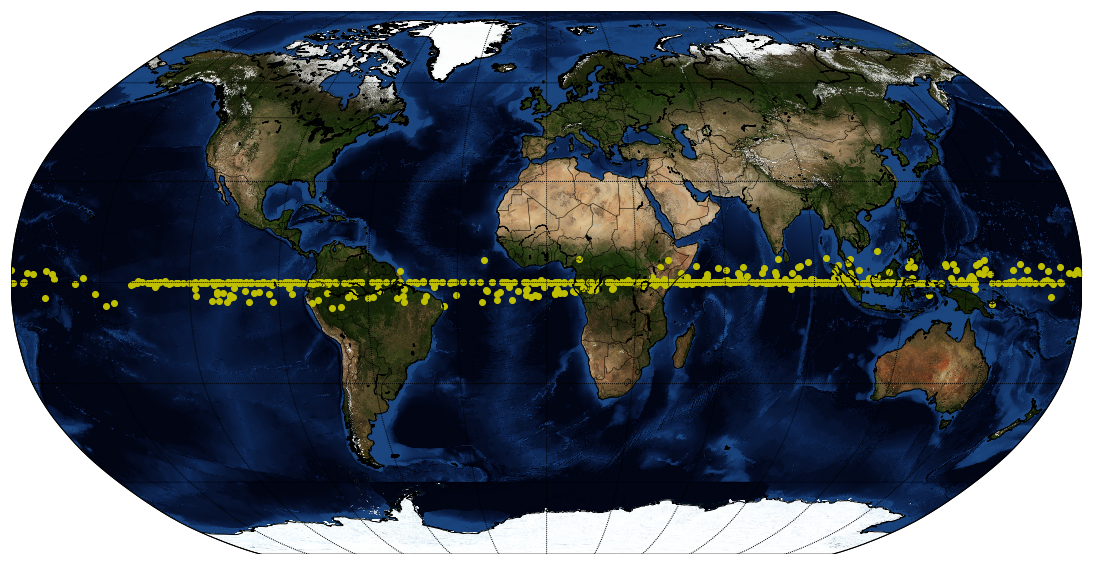

In [90]:
mask = (mask==True).T[0]
plot_map(data_final,mask.T,True)